In [2]:
import numpy as np
import scipy.spatial as scsp

import sys
sys.path.insert(0, '/home/misa/APDFT/prototyping/atomic_energies/')

import parse_density_files as pdf
import alchemy_tools2 as at

import matplotlib
#matplotlib.use('Qt5Agg')
from matplotlib import pyplot as plt
matplotlib.rcParams["font.size"] = 20

In [3]:
# for every box size

    # load vasp file

    # for every radius
        # extract density
        # calculate integral for electrostatic interaction
        # store value of integral

In [ ]:
def get_integrals_box(density, gpts, nuclei, radii):
    """
    return value of integrals for different vdW for one boxsize
    """
    estat_int = []
    for r in radii:
        estat_int.append( get_integral_radius(density, gpts, nuclei, r) )
    return(np.array(estat_int))
        
def get_integral_radius(density, gpts, nuclei, radius):
    """
    return value of integral for one multiple of the vdW radii
    """
    
    # set density to zero outside of integration radius
    density_bound = generate_bound_density(density, nuclei, radius, gpts)

    # calculate integral for new density
    estat_int = at.calculate_atomic_energies(density_bound, nuclei, gpts, h_matrix)
    
    return(estat_int)
    
def generate_bound_density(density, nuclei, radius, gpts):
    # reshape into vectors
    density_flattened = density.flatten()
    gpts_flattened = at.meshgrid2vector(gpts)
    
    # get density grid points lying within the weighted vdW radii
    all_idc_in = get_all_idc_in(nuclei, radius, gpts_flattened)
    # get indices of all gridpoints as flattened 1D-array
    all_idc = np.arange(len(density_flattened))
     # get density grid points lying out of the weighted vdW radii
    all_idc_out = at.get_all_idc_out(all_idc_in, all_idc)
    
    # set density out of weighted vdW radii to zero
    density_flattened[all_idc_out] = 0.0
    # reshape flattened density to grid
    density_bound = density_flattened.reshape((density.shape))
    return(density_bound)
        
def get_all_idc_in(nuclei, radius, gpts_flattened):
    all_idc_in = []
    for n in nuclei:
        r_vdW = lookup_vdW(n[0])
        all_idc_in.append(at.get_idc_rvdW(np.array([n[1:4]]), r_vdW*radius, gpts_flattened))
    return(all_idc_in)
   
from ase.units import Bohr
def lookup_vdW(Z, unit = 'Bohr'):
    """
    return van der Waals radius for element
    from Bondi J. Phys. Chem 68, 1964
    """
    
    if Z == 1:
        r_w = 1.2
    elif Z == 6:
        r_w = 1.7
    elif Z == 7:
        r_w = 1.55
    elif Z == 8:
        r_w = 1.52
    else:
        raise Exception("r_w not implemented for Z = {}".format(Z))
        
    if unit == 'Bohr':
        r_w /= Bohr
    return(r_w)
    

## Calculation of alchemical potential etc. for different density cutoffs for one $\lambda$-value

In [ ]:
# boxes = ['/home/misa/APDFT/prototyping/atomic_energies/results/test_calculations/converge_lambda_test/boxsize/box30/ve8_stepsize/ve_08.cube']
# boxes = ['/home/misa/APDFT/prototyping/atomic_energies/results/test_calculations/vasp/dsgdb9nsd_001212/box20.0/CHG']
boxes = ['/home/misa/APDFT/prototyping/atomic_energies/results/slice_ve38/dsgdb9nsd_001212/cube-files/ve_08.cube']

lam_vals, dens, nuclei, gpts, h_matrix = at.load_cube_data(boxes)

In [ ]:
energies = []
radii = [0.5, 1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 7.0]
for r in radii:
    dens_b = generate_bound_density(dens, nuclei, r, gpts)[0]
    estat_int = at.calculate_atomic_energies(dens_b, nuclei, gpts, h_matrix)
    energies.append(estat_int[1])

### plot of projected density

In [ ]:
# cube=pdf.CUBE(boxes[0])

In [ ]:
fig,ax = plt.subplots(1,1)
ax.plot(cube.get_axis('x'),cube.project((0,2)))
ax.set_xlabel(r'cell coordinate $q$ (Ang)')
ax.set_ylabel(r'$\int dq_1 dq_2 \rho(\vec{q})$')
# plt.savefig('/home/misa/projects/Atomic-Energies/figures/density_shoulders/density_cutoff/dsgdb9nsd_001212_projection02.png', bbox_inches='tight')

## Plot of of alchemical potential etc for different density cutoffs for one $\lambda$-value

In [ ]:
h,c,n,o=0,0,0,0
fig,ax = plt.subplots(1,1)
for i,z in zip(range(len(energies[0])), nuclei[:,0]):
    if z == 1:
        if h==0:
            ax.plot(radii,np.array(energies)[:,i], '--|', markersize=10, label='H')
            h=1
        else:
            ax.plot(radii,np.array(energies)[:,i], '--|', markersize=10)
    if z == 6:
        if c==0:
            ax.plot(radii,np.array(energies)[:,i], '--v', label='C')
            c=1
        else:
            ax.plot(radii,np.array(energies)[:,i], '--v')
    if z == 7:
        if n==0:
            ax.plot(radii,np.array(energies)[:,i], '--s', label='N')
            n=1
        else:
            ax.plot(radii,np.array(energies)[:,i], '--s')
    if z == 8:
        if o==0:
            ax.plot(radii,np.array(energies)[:,i], '--d', label='O')
            o=1
        else:
            ax.plot(radii,np.array(energies)[:,i], '--d')
        
ax.set_xlabel(r'scaling coefficient $r$')
ax.set_ylabel(r'$\int_{\Omega_r} d\vec{r} \frac{\rho(\vec{r})}{|\vec{r}-\vec{R}_I|} $')
ax.legend(frameon=False)
# plt.savefig("/home/misa/projects/Atomic-Energies/figures/density_shoulders/density_cutoff/dsgdb9nsd_001212_alchpot_lam0p8.png", bbox_inches='tight')
# plt.savefig("/home/misa/projects/Atomic-Energies/figures/density_shoulders/density_cutoff/dsgdb9nsd_001212_atomic_energies_lam0p8.png", bbox_inches='tight')

## Plot of density projection and alchpot for different cutoffs

In [ ]:
# plots also density projections for cut density
fig, ax = plt.subplots(1,3)
energies = []
radii = [0.5, 1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 7.0]
for r in radii:
    dens_b = generate_bound_density(dens, nuclei, r, gpts)[0]
    estat_int = at.calculate_atomic_energies(dens_b, nuclei, gpts, h_matrix)
    energies.append(estat_int[2])
#     pr01 = dens_b.sum(axis=(0,1))
    ax[0].plot(dens_b.sum(axis=(0,1)), label = 'vdW multiple = {}'.format(r))
    ax[1].plot(dens_b.sum(axis=(0,2)), label = 'vdW multiple = {}'.format(r))
    ax[2].plot(dens_b.sum(axis=(1,2)), label = 'vdW multiple = {}'.format(r))
for i in range(3):
    ax[i].legend()

## Plot of SHIFTED alchemical potential etc for different density cutoffs for one $\lambda$-value 

In [28]:
en2=np.load('/home/misa/APDFT/prototyping/atomic_energies/results/slice_ve38/dsgdb9nsd_001212/radius_alchpots.npy')

# main_path = '/home/misa/APDFT/prototyping/atomic_energies/results/slice_ve38/dsgdb9nsd_014656/'
# en2=np.load('/home/misa/APDFT/prototyping/atomic_energies/results/slice_ve38/dsgdb9nsd_014656/radius_alchpots_ve38.npy')
# nuclei = np.loadtxt(main_path+'atomic_energies_with_mic.txt')
radii = [0.5, 1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 7.0]
# shift energies to value at radius = 3.0
energies_norm = en2-en2[5]

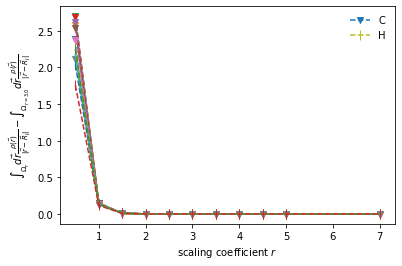

In [29]:
h,c,n,o=0,0,0,0
fig,ax = plt.subplots(1,1)
for i,z in zip(range(len(energies_norm[0])), nuclei[:,0]):
    if z == 1:
        if h==0:
            ax.plot(radii,np.array(energies_norm)[:,i], '--|', markersize=10, label='H')
            h=1
        else:
            ax.plot(radii,np.array(energies_norm)[:,i], '--|', markersize=10)
    if z == 6:
        if c==0:
            ax.plot(radii,np.array(energies_norm)[:,i], '--v', label='C')
            c=1
        else:
            ax.plot(radii,np.array(energies_norm)[:,i], '--v')
    if z == 7:
        if n==0:
            ax.plot(radii,np.array(energies_norm)[:,i], '--s', label='N')
            n=1
        else:
            ax.plot(radii,np.array(energies_norm)[:,i], '--s')
    if z == 8:
        if o==0:
            ax.plot(radii,np.array(energies_norm)[:,i], '--d', label='O')
            o=1
        else:
            ax.plot(radii,np.array(energies_norm)[:,i], '--d')
        
ax.set_xlabel(r'scaling coefficient $r$')
ax.set_ylabel(r'$\int_{\Omega_r} d\vec{r} \frac{\rho(\vec{r})}{|\vec{r}-\vec{R}_I|} - \int_{\Omega_{r=3.0}} d\vec{r} \frac{\rho(\vec{r})}{|\vec{r}-\vec{R}_I|}$')
ax.legend(frameon=False)
# plt.savefig("/home/misa/projects/Atomic-Energies/figures/density_shoulders/density_cutoff/dsgdb9nsd_001212_alchpot_lam0p8_shifted.png", bbox_inches='tight')
# plt.savefig("/home/misa/projects/Atomic-Energies/figures/density_shoulders/density_cutoff/dsgdb9nsd_001212_atomic_energies_lam0p8_shifted.png", bbox_inches='tight')

### Determine optimal scaling coefficient
- Plot max delta for different compounds
- Plot ratio max/min slope around shifted scaling coefficient $r_s$

In [9]:
import scipy as sc
def get_slopes(x_data, y_data):
    slopes = []
    for i in range(y_data.shape[1]):
        res=sc.stats.linregress(x_data, y_data[:,i])
        slopes.append(res[0])
    return(np.array(slopes))
        

In [12]:
# list of compounds and basepath
main = '/home/misa/APDFT/prototyping/atomic_energies/results/slice_ve38/'
comps = ['dsgdb9nsd_001212', 'dsgdb9nsd_003712', 'dsgdb9nsd_003886', 'dsgdb9nsd_002626', 'dsgdb9nsd_014656','dsgdb9nsd_000228', 'dsgdb9nsd_002025','dsgdb9nsd_002900','dsgdb9nsd_001442','dsgdb9nsd_003727']

# p_alch = '/home/misa/APDFT/prototyping/atomic_energies/results/slice_ve38/dsgdb9nsd_001212/radius_alchpots.npy'
# p_aten = '/home/misa/APDFT/prototyping/atomic_energies/results/slice_ve38/dsgdb9nsd_001212/radius_energies.npy'

### Method 1

In [43]:
extremum_comp = dict()
for p in comps:
    # load data for compound
    p_alch = main+p+'/radius_alchpots_ve38.npy'
    alch_pots = np.load(p_alch)
#     p_aten = main+p+'/radius_energies_ve30.npy'
#     at_en = np.load(p_aten)
    radii = np.array([0.5, 1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 7.0])
    
    # pick max deviation in alchemical potential of scaling coefficients adjacent to shift coefficient
    extremum = []
    for center in range(3,9):
        alch_pots_norm = alch_pots - alch_pots[center]
#         compare absolute values
        lower = np.amax(alch_pots_norm[center-1])-np.amin(alch_pots_norm[center-1])
        upper = np.amax(alch_pots_norm[center+1])-np.amin(alch_pots_norm[center+1])
        extremum.append(max(upper,lower))
    extremum = np.array(extremum)
    extremum_comp[p] = extremum

Text(0.5, 0, 'scaling coefficient $r_s$')

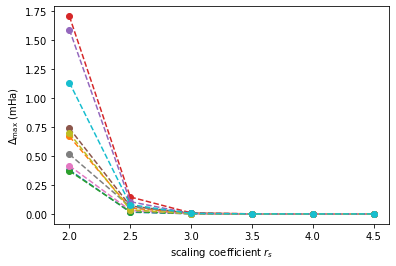

In [44]:
fig, ax = plt.subplots(1,1)
for k in extremum_comp.keys():
    ax.plot(radii[3:9], extremum_comp[k]*1000, '--o', label=k.split('_')[1])
#ax.legend()
ax.set_ylabel(r'$ \Delta_{\rm{max}}$ (mHa)')
ax.set_xlabel(r'scaling coefficient $r_s$')
# plt.savefig('/home/misa/projects/Atomic-Energies/figures/density_shoulders/density_cutoff/opt_rs_m1_.png', bbox_inches="tight")

Text(0.5, 0, 'scaling coefficient $r_s$')

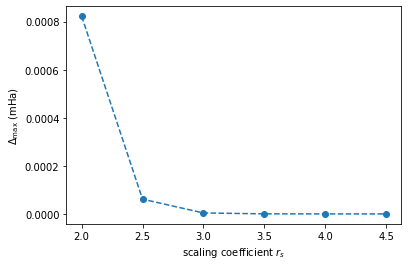

In [47]:
# averaged over all compounds
shp = len(extremum_comp[list(extremum_comp.keys())[0]])
average = np.zeros(shp)

for k in extremum_comp.keys():
    average += extremum_comp[k]
average /= len(extremum_comp.keys())

fig, ax = plt.subplots(1,1)

ax.plot(radii[3:9], average, '--o', label=k.split('_')[1])
#ax.legend()
ax.set_ylabel(r'$ \Delta_{\rm{max}}$ (mHa)')
ax.set_xlabel(r'scaling coefficient $r_s$')
# plt.savefig('/home/misa/projects/Atomic-Energies/figures/density_shoulders/density_cutoff/opt_rs_m1_mean_.png', bbox_inches="tight")

### Method 2

In [37]:
extremum_comp = dict()
for p in comps:
    # load data for compound
#     p_alch = main+p+'/radius_alchpots_ve38.npy'
    p_alch = main+p+'/radius_alchpots_ve38.npy'
    alch_pots = np.load(p_alch)
#     p_aten = main+p+'/radius_energies_ve30.npy'
#     at_en = np.load(p_aten)
    radii = np.array([0.5, 1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 7.0])
    
    # pick max deviation in alchemical potential of scaling coefficients adjacent to shift coefficient
    extremum = []
    for center in range(3,9):
        alch_pots_norm = alch_pots - alch_pots[center]

#         compare slopes relatively
        slopes = get_slopes(radii[center-1:center+2],alch_pots_norm[center-1:center+2])
        extremum.append(np.amin(slopes)/np.amax(slopes))
        

    extremum = np.array(extremum)
    extremum_comp[p] = extremum

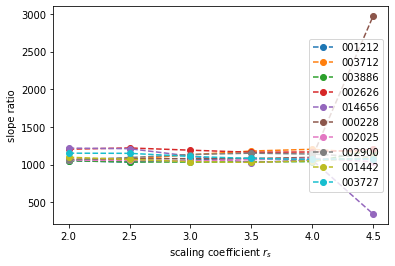

In [39]:
fig, ax = plt.subplots(1,1)
for k in extremum_comp.keys():
    ax.plot(radii[3:9], extremum_comp[k]*1000, '--o', label=k.split('_')[1])
ax.legend()
ax.set_ylabel(r'slope ratio')
ax.set_xlabel(r'scaling coefficient $r_s$')
# plt.savefig('/home/misa/projects/Atomic-Energies/figures/density_shoulders/density_cutoff/opt_rs_m2_.png', bbox_inches="tight")

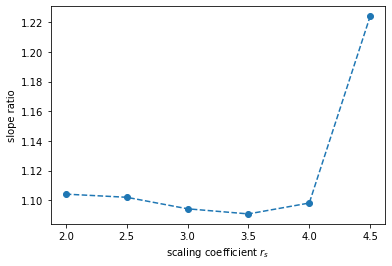

In [42]:
# averaged over all compounds
shp = len(extremum_comp[list(extremum_comp.keys())[0]])
average_slope_ratio = np.zeros(shp)

for k in extremum_comp.keys():
    average_slope_ratio += extremum_comp[k]
average_slope_ratio /= len(extremum_comp.keys())

fig, ax = plt.subplots(1,1)

ax.plot(radii[3:9], average_slope_ratio, '--o')
#ax.legend()
ax.set_ylabel(r'slope ratio')
ax.set_xlabel(r'scaling coefficient $r_s$')
# plt.savefig('/home/misa/projects/Atomic-Energies/figures/density_shoulders/density_cutoff/opt_rs_m2_mean_.png', bbox_inches="tight")

## Learning curves after density cutoff

In [ ]:
pcutoff_at = '/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/cutoff_dens/lcurves_atomisation_per_atom_cutoff4.0.txt'
pcutoff_mol = '/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/cutoff_dens/lcurves_atomisation_per_molecule_cutoff4.0.txt'
cutoff_at = np.loadtxt(pcutoff_at)
cutoff_mol = np.loadtxt(pcutoff_mol)

pat = '/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/mic/lcurve_atomisation_atomic.txt'
pmol = '/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/mic/lcurve_atomisation_molecule.txt'
at = np.loadtxt(pat)
mol = np.loadtxt(pmol)

In [ ]:
fig, ax = plt.subplots(1,1)

labels = ['cutoff atom', 'cutoff molecule', 'atom', 'molecule']
data = [cutoff_at, cutoff_mol, at, mol]

for c in zip(data, labels):
    ax.plot(c[0][:,0], c[0][:,1], '-o', label = c[1])
plt.legend(prop={'size':12}, frameon=False)
ax.set_xlabel('# Molecules')
ax.set_ylabel('MAE (Ha)')
ax.set_xscale('log')
ax.set_yscale('log')
# plt.savefig('/home/misa/projects/Atomic-Energies/figures/density_shoulders/density_cutoff/lcurves_atomisation.png', bbox_inches="tight")

## Learning Curves for different density cutoffs

In [2]:
import numpy as np
from matplotlib import pyplot as plt

In [9]:
base = '/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/plot_lcurve_vs_sigma/'
pc2 = 'lcurve_cutoff_2.0_sigma_477.7128916668455.txt'
pc3 = 'lcurve_cutoff_3.0_sigma_477.7128916668455.txt'
pc4 = 'lcurve_cutoff_4.0_sigma_477.7128916668455.txt'
pnoc = 'lcurve_477.7128916668455.txt'

paths = [base+pc2, base+pc3, base+pc4, base+pnoc]

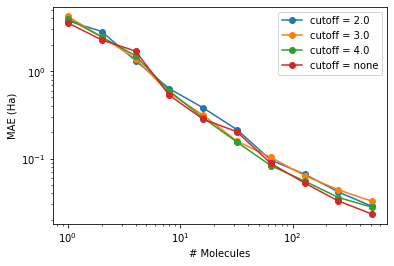

In [16]:
fig, ax = plt.subplots(1,1)
labels = ['2.0', '3.0', '4.0', 'none']

for p in zip(paths, labels):
    d = np.loadtxt(p[0])
    ax.plot(d[:,0], d[:,1], '-o', label='cutoff = '+p[1])
    
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('# Molecules')
ax.set_ylabel('MAE (Ha)')
ax.legend()

In [14]:
d

array([[1.00000000e+00, 3.55094593e+00, 6.82292894e-02],
       [2.00000000e+00, 2.26735763e+00, 3.24031996e-01],
       [4.00000000e+00, 1.69034701e+00, 3.35912057e-01],
       [8.00000000e+00, 5.28660504e-01, 4.11936902e-02],
       [1.60000000e+01, 2.82026913e-01, 1.33271814e-02],
       [3.20000000e+01, 2.02762062e-01, 3.43422048e-02],
       [6.40000000e+01, 8.81290992e-02, 6.98922405e-03],
       [1.28000000e+02, 5.27016037e-02, 7.51150493e-03],
       [2.56000000e+02, 3.27414436e-02, 7.04018936e-04],
       [5.12000000e+02, 2.32411061e-02, 1.09690128e-03]])

# multiple density files
see run_scripts/run_atomisation_cutoff.py

In [ ]:
# cutoff radius (multiples of bohr radius)
cradius = 4.0

# paths to the compounds
#dirs = concatenate_files(['/home/misa/APDFT/prototyping/atomic_energies/results/slice_ve38/paths_atomic_energies'])

dirs = ['/home/misa/APDFT/prototyping/atomic_energies/results/slice_ve38/dsgdb9nsd_001212/']
for compound_path in dirs:
    print("entering directory {}".format(compound_path))
    # paths to the cube files
    base = compound_path
    base = base + 'cube-files/'
    cubes = ['ve_8.cube', 've_15.cube', 've_23.cube', 've_30.cube', 've_38.cube']
    for i in range(len(cubes)):
        cubes[i] = base + cubes[i]

    path_to_ueg = '/home/misa/APDFT/prototyping/atomic_energies/results/slice_ve38/ueg/ve_00.cube'
    cubes.insert(0, path_to_ueg)

    # load
    print("loading density")
    lam_vals, densities, nuclei, gpts, h_matrix = at.load_cube_data(cubes)
    # set density to zero at lambda = 0.0 since we treat system with infinitely large box
    densities[0].fill(0.0)

    print("cutting density")
    for i,d in enumerate(densities):
        dens_b = generate_bound_density(d, nuclei, cradius, gpts)
        densities[i] = dens_b
    


    # atomic energy decomposition
    print("calculate atomic energies")
    nuclei, atomic_energies_with_repulsion, atomic_energies, alch_pots = at.atomic_energy_decomposition(lam_vals, densities, nuclei, gpts, h_matrix)


# difference in energy for symmetric atoms

In [ ]:
boxes = ['/home/misa/APDFT/prototyping/atomic_energies/results/slice_ve38/dsgdb9nsd_001212/cube-files/ve_8.cube']
lam_vals, dens, nuclei, gpts, h_matrix = at.load_cube_data(boxes)
energies = []
radii = [0.5, 1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 7.0]
for r in radii:
    dens_b = generate_bound_density(dens, nuclei, r, gpts)[0]
    estat_int = at.calculate_atomic_energies(dens_b, nuclei, gpts, h_matrix)
    energies.append(estat_int)

In [ ]:
nuclei

In [ ]:
# no cutoff
energies.append(at.calculate_atomic_energies(dens, nuclei, gpts, h_matrix))

In [ ]:
alch_h1 = []
alch_h2 = []
alch_h3 = []
alch_h4 = []

for i in range(len(radii)+1):
    alch_h1.append(energies[i][2][8])
    alch_h2.append(energies[i][2][9])
    
    alch_h3.append(energies[i][2][10])
    alch_h4.append(energies[i][2][11])
    
alch_h1 = np.array(alch_h1)
alch_h2 = np.array(alch_h2)

alch_h3 = np.array(alch_h3)
alch_h4 = np.array(alch_h4)

radii2 = radii.copy()
radii2.append(10.0)

In [ ]:
plt.plot(radii2, alch_h1)
plt.plot(radii2, alch_h2, '--')

plt.plot(radii2, alch_h3)
plt.plot(radii2, alch_h4, '--')

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(radii2,(alch_h1-alch_h2)*1000, '-o', label=r'CH$_3$')
ax.plot(radii2,(alch_h4-alch_h3)*1000, '-o', label=r'CH$_2$')
ax.set_xlim([0.0,10.0])
ax.set_ylim([-0.4,0.1])
ax.set_ylabel(r'$\Delta$ alchemical (mHa)')
ax.set_xlabel('scaling coefficient')
ax.legend(loc='lower right')
# plt.savefig('/home/misa/projects/Atomic-Energies/figures/density_shoulders/density_cutoff/dsgdb9nsd_001212_alchpot_symmetricH.png', bbox_inches="tight")

In [ ]:
(-5.910958466186044369e+00--5.910360650854097564e+00)*1000

In [ ]:
full_box = np.loadtxt('/home/misa/APDFT/prototyping/atomic_energies/results/slice_ve38/dsgdb9nsd_001212/atomic_energies_with_mic_repulsion.txt')
alch=full_box[:, 4]
atomic=full_box[:, 5]
atomisation=full_box[:, 6]
atomisation_rep=full_box[:, 7]

In [ ]:
alch

In [ ]:
atomic

# Implementation prototype

## Determine volume of bound electrons - density extraction

Preparation of data, such that only density in spheres around nuclei is used for calculation of atomic energies

strategy: set density out side of radii to zero, then these gridpoints do not contribute to the integral $\int d\vec{r} \frac{\tilde{\rho}}{|\vec{r}-\vec{R_I}|}$

this way after loading the density files; an additional step is carried out as implemented in this notebook
in this step the density array is changed as described above; then the atomic energies can be calculated as already implemented without any changes to the existing code

In [ ]:
import numpy as np
import scipy.spatial as scsp

import sys
sys.path.insert(0, '/home/misa/APDFT/prototyping/atomic_energies/')

import parse_density_files as pdf

In [ ]:
def meshgrid2vector(grid):
    """
    convert components of meshgrid into set of vectors; every vector is a point of the grid
    e.g. a 3D grid is converted in a numpy array of shape (number gridpoints, 3)
    """
    flattened_grid = []
    for c in grid:
        flattened_grid.append(c.flatten())
        
    return(np.array(flattened_grid).T)
    

# get grid points lying in sphere with radius r_vdW

def get_idc_rvdW(center, rvdw, gpts):
    """
    returns indices of grid points lying in a sphere around center with radius rdwV
    
    center: center of sphere
    rdvw: radius of sphere
    coordinates of grid as flattened numpy array, shape (number of grid points, dimension of grid)
    """
    
    # distance of every gridpoint from center
    distance_array = scsp.distance.cdist(gpts, center)
    
    
    idc_in_sphere = np.where(distance_array[:, 0] <= rvdw)[0] # indices of points within sphere with vdW radius
    idc_out_sphere = np.where(distance_array[:, 0] > rvdw)[0] # indices of points out of sphere with vdW radius
    
    return(idc_in_sphere, idc_out_sphere)

In [ ]:
# load data

In [ ]:
path = '/home/misa/APDFT/prototyping/atomic_energies/results/slice_ve38/dsgdb9nsd_002626/cube-files/ve_8.cube'
cube = pdf.CUBE(path)

In [ ]:
# prepare data

In [ ]:
grid = cube.get_grid()
density = cube.data_scaled
np.amax(density)

In [ ]:
nucleus = np.array([[10.0, 10.0, 10.0]])
radius = 5.0

nucleus2 = np.array([[20.0, 10.0, 10.0]])
radius2 = 7.0

In [ ]:
# get indices within and out of radius around nuclei

In [ ]:
idc_in, idc_out = get_idc_rvdW(nucleus, radius, meshgrid2vector(grid))
idc_in2, idc_out2 = get_idc_rvdW(nucleus2, radius2, meshgrid2vector(grid))

In [ ]:
idc_in

In [ ]:
# select all indices that are within at least one radius for one nucleus

In [ ]:
print(idc_in.shape)
print(idc_in2.shape)
print(idc_in.shape[0]+idc_in2.shape[0])
print(np.concatenate([idc_in, idc_in2]).shape)

In [ ]:
all_idc_in = np.concatenate((idc_in, idc_in2))
all_idc_in = np.unique(all_idc_in)
print(all_idc_in.shape)

In [ ]:
# select all indices that are NOT within at least one radius for one nucleus

In [ ]:
all_idc_out = np.setdiff1d(np.arange(np.prod(density.shape)), all_idc_in, assume_unique=True)

In [ ]:
# set density around nuclei to zero

In [ ]:
density_flattened = density.flatten()
density_flattened[all_idc_out] = 0.0

In [ ]:
density = density_flattened.reshape(density.shape)
np.amax(density)

# Some tests

In [ ]:
import numpy as np
import scipy.spatial as scsp

import sys
sys.path.insert(0, '/home/misa/APDFT/prototyping/atomic_energies/')

import parse_density_files as pdf

In [ ]:
# import test data

In [ ]:
path = '/home/misa/APDFT/prototyping/atomic_energies/results/slice_ve38/dsgdb9nsd_002626/cube-files/ve_8.cube'
cube = pdf.CUBE(path)

In [ ]:
# calculate distance between center point in cell and gridpoints

In [ ]:
grid = cube.get_grid()
x = grid[0].flatten()
y = grid[1].flatten()
z = grid[2].flatten()

distance_array = scsp.distance.cdist(np.array([x,y,z]).T, np.array([[10,10,10]]))

In [ ]:
# select points within certain distance from center point

In [ ]:
np.where(distance_array[:,0] <= 5)[0]

In [ ]:
distance_array[:,0]

In [ ]:
np.where(distance_array <= 5)[0].shape

In [ ]:
np.where(distance_array <= 5)

In [ ]:
# make sure that shapes of inputs are equal

In [ ]:
np.array([[10,10,10]]).shape # shape center point

In [ ]:
np.array([x,y,z]).T.shape # shape grid

In [ ]:
scsp.distance.cdist(np.array([x,y,z]).T, np.array([[10,10,10]])).shape

In [ ]:
# Test if correct distance

In [ ]:
np.linalg.norm(np.array([37.578606, 37.578606, 37.578606]) - np.array([[10,10,10]]))

In [ ]:
np.sqrt(3*27**2)

In [ ]:
def meshgrid2vector(grid):
    """
    convert components of meshgrid into set of vectors; every vector is a point of the grid
    e.g. a 3D grid is converted in a numpy array of shape (number gridpoints, 3)
    """
    flattened_grid = []
    for c in grid:
        flattened_grid.append(c.flatten())
        
    return(np.array(flattened_grid).T)
    

# get grid points lying in sphere with radius r_vdW

def get_idc_rvdW(center, rvdw, gpts):
    """
    returns indices of grid points lying in a sphere around center with radius rdwV
    
    center: center of sphere
    rdvw: radius of sphere
    coordinates of grid as flattened numpy array, shape (number of grid points, dimension of grid)
    """
    
    # distance of every gridpoint from center
    distance_array = scsp.distance.cdist(gpts, center)
    
    
    idc_in_sphere = np.where(distance_array[:, 0] <= rvdw) # indices of points within sphere with vdW radius
    idc_out_sphere = np.where(distance_array[:, 0] > rvdw) # indices of points out of sphere with vdW radius
    
    return(idc_in_sphere, idc_out_sphere)
    

In [ ]:
# set density for points out of distance to center point to zero

In [ ]:
density_flattened = np.reshape(cube.data, 175**3)
idc_in, idc_out = get_idc_rvdW(np.array([[10,10,10]]), 5.0, meshgrid2vector(grid))
density_flattened[idc_out] = 0.0

In [ ]:
density_flattened.reshape((175, 175, 175))

In [ ]:
# make sure that reshaping is fine

In [ ]:
np.array_equal(np.array([np.reshape(grid[0], 175**3), np.reshape(grid[1], 175**3), np.reshape(grid[2], 175**3)]).T, meshgrid2vector(grid))

In [ ]:
np.array_equal(meshgrid2vector(grid),np.array([x,y,z]).T)